### Описание данных

*5_task_1*:

- id – id клиента в эксперименте
- group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
- events – сколько блюд суммарно было заказано за период

*5_task_2*:

- id – id клиента в эксперименте
- segment – сегмент (high/low)
- group – вид кнопки (control – старая версия, test – новая версия)
- events – сколько блюд суммарно было заказано за период

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

In [4]:
import scipy.stats as st

import statsmodels.formula.api as smf 
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)

import pingouin as pg

### 1.

Итак, первая задача: нужно проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

- A – прямоугольные 16:9
- B – квадратные
- C – прямоугольные 12:4

Для сравнения средних в данном случае я буду использовать тест **ANOVA** (потому что три группы)

In [5]:
exp1 = pd.read_csv("https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/iRcyB5PS8JB1lw")
exp1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


### 2. Проверю, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [7]:
A = exp1.query("group == 'A'").events
B = exp1.query("group == 'B'").events
C = exp1.query("group == 'C'").events

In [8]:
#проверка дисперсий(являются ли примерно одинаковыми) через scipy (>0,05 не отклоняем нулевую гипотезу)

ss.levene(A, B, C)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [9]:
#через pingoin
pg.homoscedasticity(data=exp1, dv="events", group="group")

,W,pval,equal_var
levene,2.26226,0.104133,True


**p-value > 0.05, не отклоняем нулевую гипотезу**

### 3.

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность  сделала семплирование, так как на больших выборках можно получить неверные результаты. Для воспроизводимости результата использовала параметр random_state=17 в методе sample.

In [11]:
#шапиро
pg.normality(data=exp1, dv="events", group="group", method = "shapiro")

,W,pval,normal
A,0.998942,0.000004,False
B,0.999016,0.000011,False
C,0.998921,0.000003,False


In [12]:
pg.normality(data=exp1, dv="events", group="group", method="normaltest")

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


<AxesSubplot:title={'center':'Q-Q Plot'}, xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

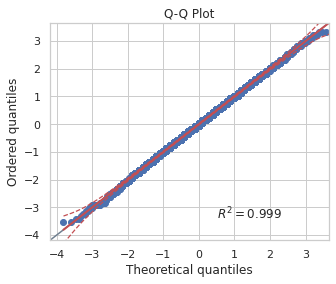

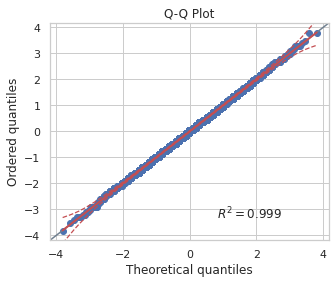

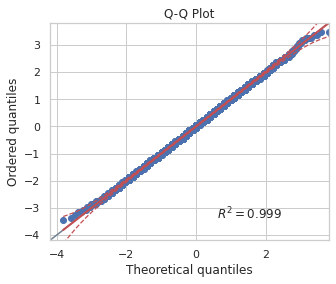

In [13]:
#qq-plots
pg.qqplot(A)
pg.qqplot(B)
pg.qqplot(C)

Распределения events в группах являются нормальными

### 4. Провести тест

In [14]:
ss.f_oneway(A, B, C) #однофакторный дисперсионный анализ

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [15]:
#pingouin
pg.anova(data=exp1, dv="events", between="group")

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


Для сравнения средних я использовала **однофакторный дисперсионный анализ**. Статистика в тесте равна **2886**, p-value **0.0**.

### 5. Определения статистически значимых различий между группами с помощью критерия Тьюки

In [19]:
#тьюки поправки

pg.pairwise_tukey(data=exp1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [18]:
#statsmodels
MultiComp = MultiComparison(exp1['events'], groups=exp1['group'])

print(MultiComp.tukeyhsd().summary())

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Text(0, 0.5, 'Число покупок')

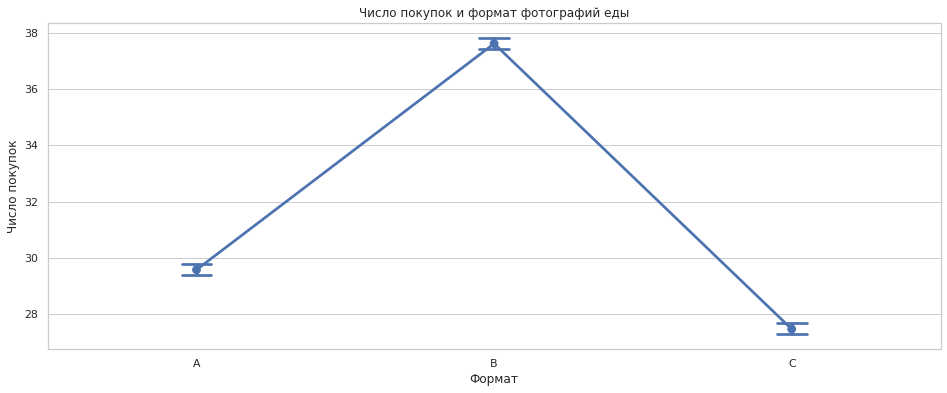

In [20]:
sns.pointplot(x = 'group', y = 'events', data = exp1, capsize = .1)
plt.title('Число покупок и формат фотографий еды')
plt.xlabel('Формат')
plt.ylabel('Число покупок')

In [21]:
# statsmodels.stats.multicomp
pairwise_tukeyhsd(exp1.events, exp1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [22]:
#геймс-хоувелл

pg.pairwise_gameshowell(data=exp1, dv="events", between="group")

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140920,-57.011134,19987.258491,0.001,-0.806229
1,A,C,29.5796,27.4703,2.1093,0.141696,14.886135,19995.116233,0.001,0.210514
2,B,C,37.6136,27.4703,10.1433,0.140062,72.420220,19995.502469,0.001,1.024138


In [23]:
pg.pairwise_ttests(data=exp1, dv="events", between="group", padjust="bonf")

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


### Вывод:


Будем использовать **B – квадратные** картинки, потому что среднее наибольшее и статистически значимо отличается от A & C

### Второй эксперимент

### 7.
Во втором эксперименте требовалось проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Буду использовать **многофакторный дисперсионный анализ**

In [26]:
exp2 = pd.read_csv('https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/NqeZSGmq5O3iFw')

In [27]:
exp2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


### 8

Посмотрим на данные. Для начала визуализирую распределение events для контрольной и тестовой групп. Соотнесу графики распределения и экспериментальные группы:

<AxesSubplot:xlabel='events', ylabel='Count'>

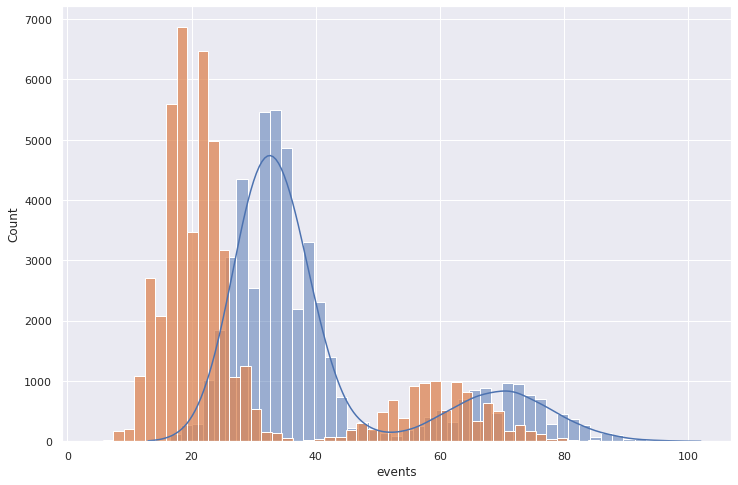

In [29]:
sns.set(rc={'figure.figsize':(12,8)})
sns.histplot(data =exp2.query("group == 'test'"), x="events", bins = 50, kde=True)
sns.histplot(data =exp2.query("group == 'control'"), x="events", bins = 50 )

## 9. Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

Узнаем стандартное отклонение для пользователей из сегмента high и контрольной группы

In [30]:
exp2.groupby(['group', 'segment']).events.describe().round(2)

count   mean   std   min   25%   50%   75%    max
group   segment                                                     
control high     10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

In [31]:
exp2.groupby(['group', 'segment'])['events'].describe().T.round(2)

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

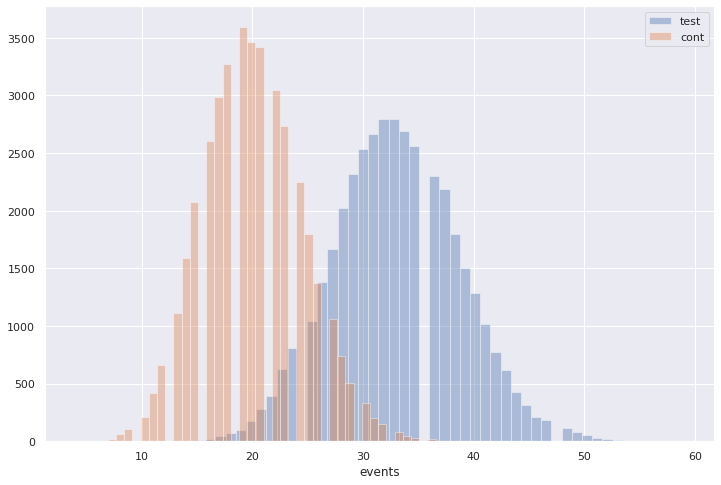

In [32]:
sns.distplot(exp2.query("segment == 'low' & group=='test'").events, label='test', kde=False)
sns.distplot(exp2.query("segment == 'low' & group=='control'").events, label='cont', kde=False)
plt.legend()

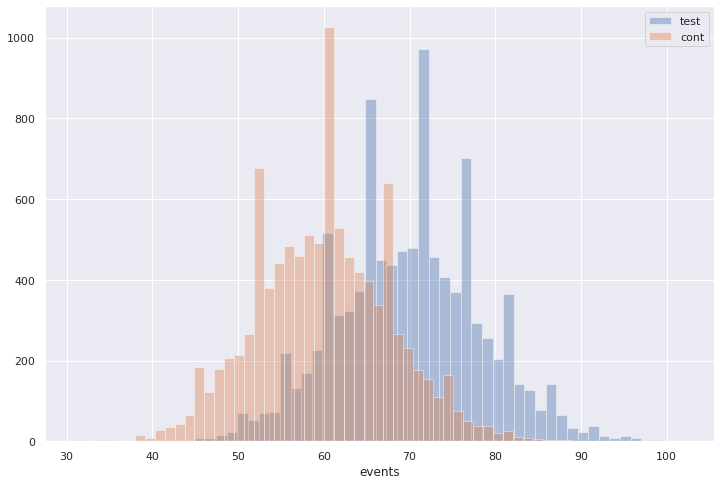

In [33]:
sns.distplot(exp2.query("segment == 'high' & group=='test'").events, label='test', kde=False)
sns.distplot(exp2.query("segment == 'high' & group=='control'").events, label='cont', kde=False)
plt.legend()

### 10. Выбор формулы для модели

Напомним, что необходимо проверить эффект нескольких переменных – group и segment на events, с взаимодействием факторов.

Буду использовать формулу:

- events ~ segment + group + segment:group'

### 11. Тест, визуализация результатов

In [36]:
model = smf.ols(formula = 'events ~ segment + group + segment:group', data=exp2).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [38]:
#statsmodels
model = smf.ols(formula='events ~ segment + group + segment:group', data=exp2).fit()
aov_table = anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [40]:
#взаимодействие pingouin

pg.anova(data=exp2, dv="events", between=["group", "segment"], ss_type = 2)

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


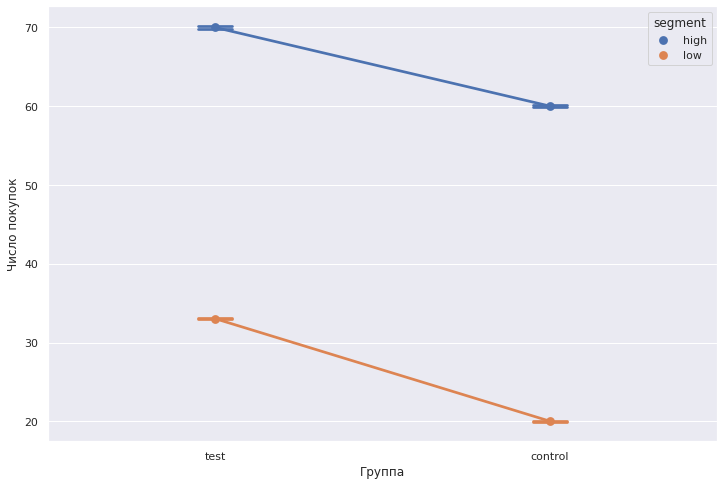

In [41]:
sns.pointplot(x = 'group', y = 'events', hue='segment', data = exp2, capsize = .1)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

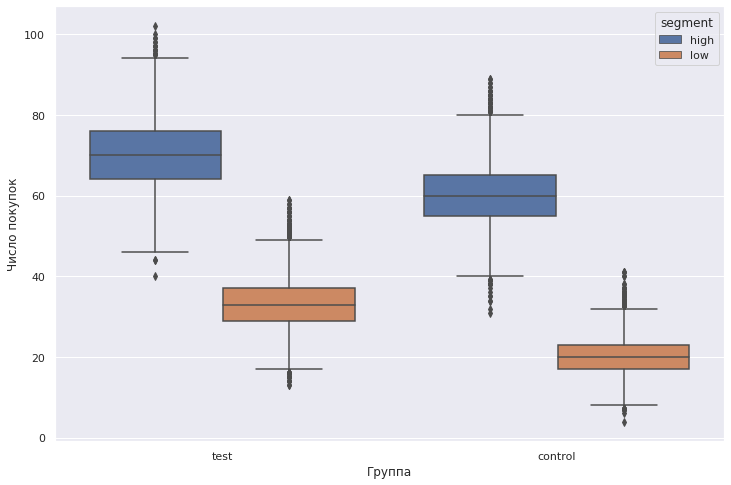

In [42]:
sns.boxplot(x = 'group', y = 'events', hue='segment', data = exp2)
plt.xlabel('Группа')
plt.ylabel('Число покупок')
plt.show()

### Вывод: 
    
- Фактор group оказался **значимым**, фактор segment – **значимым**, их взаимодействие – **значимо**. Судя по графику, для всех групп среднее значение events **увеличилось**, поэтому решение: **выкатываем новую версию**.